# STA 141B Assignment 5

Due __March 17, 2023__ by 11:59pm. Submit by editing this file and then uploading to Canvas.

Please rename this file with __"LastName_FirstName_hw5"__ 

The purpose of this assignment is to practice accessing and analyzing data in a database.

Notes: 
1. Put your answers in new cells after each exercise. You can make as many new cells as you like. Use code cells for code and Markdown cells for text. Answer all questions with complete sentences.

2. Your code should be readable; writing a piece of code should be compared to writing a page of a book. Adopt the __one-statement-per-line__ rule. The lenghth of your code should not exceed the maximum length of each cell for display. If your code is too long, you should split it into multiple lines to improve readability. (You will lose one point for each line that does not follow the rule.)

3. To help understand and maintain code, you should always add comments to explain your code. Use the hash symbol (#) to start writing a comment (homework without any comments will automatically receive 0 points). If you are writing a function, consider using _docstring_ to add explanation. 

4. Submit your final work with a __.pdf__ (or a __.html__) file to Canvas. To convert a .ipynb file to a .pdf/.html file, go to "File", click "Download as", and then click "PDF via LaTeX"/"HTML". 

5. Please do not clear your output so that we can see your answers without running all of the cells.

__For full credit, do most of your work in SQL.__ Subsetting, sorting, grouping, aggregation, and merging can all be done in SQL. It is okay to use Python code for parts of your analysis that are difficult or impossible to do in SQL, such as creating visualizations or computing statistics (other than the mean).

## Lahman's Baseball Database

In this assignment, you'll use SQL queries and __pandas__ to explore data in [Lahman's Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/), which contains "complete batting and pitching statistics from 1871 to 2020, plus fielding statistics, standings, team stats, managerial records, post-season data, and more."

We use the 2019 version for this homework. You can find the database in SQLite format in the hw5 folder on Piazza.

Documentation for the database, including a description of all tables, is in the `readme2019.txt` file included in this repository.

__Exercises:__

1. (3 points) From 2006 to 2016, which 5 teams had the highest payrolls? Payroll means the sum of the salaries for all people on the team in a given year.

In [6]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

conn = sqlite3.connect("lahmansbaseballdb.sqlite")
c = conn.cursor()
c.execute("pragma table_info(Salaries)")
results = c.fetchall()
results




[(0, 'ID', 'INTEGER', 1, None, 1),
 (1, 'yearID', 'SMALLINT', 1, None, 0),
 (2, 'teamID', 'CHARACTER(3)', 1, None, 0),
 (3, 'team_ID', 'INTEGER', 0, None, 0),
 (4, 'lgID', 'CHARACTER(2)', 1, None, 0),
 (5, 'playerID', 'VARCHAR(9)', 1, None, 0),
 (6, 'salary', 'DOUBLE', 0, None, 0)]

In [7]:
#order by total_salaries desc limit 5 

pd.read_sql_query(
    
'''

select teamID, max(payroll) as max_payroll, yearID from 

(select teamID, sum(salary) as payroll,yearID from Salaries where yearID <= 2016 and yearID >= 2006 group by teamID,yearID) 

group by teamID order by max_payroll desc limit 5

'''
                  
                  ,conn )

,teamID,max_payroll,yearID
0,NYA,231978886.0,2013
1,LAN,223362196.0,2013
2,DET,194876481.0,2016
3,BOS,188545761.0,2016
4,PHI,180944967.0,2014


2. (3 points) Is there any general trend in payrolls over this time period? (Hint: make a plot to find the trend)


Text(0, 0.5, 'Payroll')

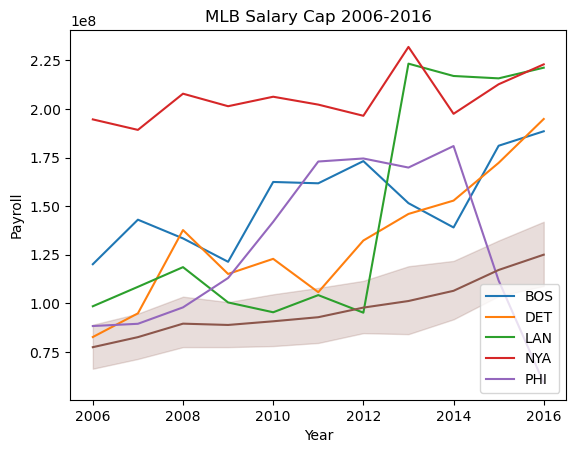

In [16]:
query = "select teamID,  sum(salary) as total_salaries, yearID  from Salaries where yearID <= 2016 and yearID >= 2006 group by teamID,yearID"
plot_df = pd.read_sql_query(query, conn)
plot_df

#fig = px.line(plot_df, x="yearID", y="total_salaries", color="teamID")
#fig.show()

#fig = px.line(plot_df.groupby("yearID")["total_salaries"].sum().reset_index(), x="yearID", y="total_salaries")
#fig.show()

sns.lineplot(x="yearID",y="total_salaries",hue="teamID",data=plot_df.loc[plot_df["teamID"].isin(["NYA","LAN","DET","BOS","PHI"])])
plt.title("MLB Total Salary Cap 2006-2016")
plt.xlabel("Year")
plt.ylabel("Payroll")



sns.lineplot(x="yearID",y="total_salaries",data=plot_df)
plt.title("MLB Salary Cap 2006-2016")
plt.xlabel("Year")
plt.ylabel("Payroll")



It seems that there is a mostly increasing trend across the entire MLB during this time period which is represented by the brown line and confidence band. The only segment that had a decrease was from 2008-2009 due to the Great Recession.

3. (2 points) There are at least 2 anomalies in the payrolls over this time period. What are they, and can you find information (online or elsewhere) to explain them?

The first anomoly that I see in the payrolls over this time period is with the LA Dodgers from 2012 to 2013 their payroll increased by about $128 million dollars

This dramatic increase is due to a change in ownership of the team in 2012. The new owners aquired lots of new high salary players which attributed to the massive increase in payroll. 

The second anomoly that I see in the payrolls over this time period is with the Philidelphia Phillies from 2014 to 2016 their payroll decreased by about $120 million dollars

In 2014 the Phillies had 4 losing seasons but still maintained their high payroll. In order to properly rebuild they reduced their payroll and traded players who had long expensive contracts reducing the overall payroll during this period. 




4. (2 points) How do the top 5 teams compare to other teams?

In [9]:
# Get a list of all numeric columns in the table
query = "SELECT name FROM PRAGMA_TABLE_INFO('Teams') WHERE type IN ('INTEGER','SMALLINT','DOUBLE')"
columns = pd.read_sql_query(query, conn)
columns = columns.loc[~columns["name"].isin( ["2B","3B","ID","yearID","div_ID","G","Ghome"])]

# Construct a dynamic SQL query to compute the average of each column
avg_columns = []
for column in columns['name']:
    avg_columns.append(f"ROUND(AVG({column}),2) AS {column}")
    

df = pd.read_sql_query(
    
f'''
with top_teams as (
select teamID from (
select teamID, max(payroll) as max_payroll from 
(select teamID, sum(salary) as payroll,yearID from Salaries where yearID <= 2016 and yearID >= 2006 group by teamID,yearID) 
group by teamID order by max_payroll desc limit 5
))

SELECT {' , '.join(avg_columns)} FROM Teams WHERE teamID IN top_teams and yearID >= 2006 and yearID <= 2016 

UNION

SELECT {' , '.join(avg_columns)} FROM Teams WHERE teamID NOT IN top_teams and yearID >= 2006 and yearID <= 2016 


'''
                  
                  ,conn )
df["teams"] = ["top_teams","not_top_teams"]

df

,teamRank,W,L,R,AB,H,HR,BB,SO,SB,...,HRA,BBA,SOA,E,DP,FP,attendance,BPF,PPF,teams
0,2.33,87.35,74.62,765.16,5573.44,1476.93,174.29,540.64,1142.95,95.87,...,161.69,498.25,1213.67,91.64,143.49,0.98,3214846.02,101.73,101.15,top_teams
1,3.15,79.71,82.25,710.48,5527.96,1422.80,160.52,503.54,1175.48,95.08,...,163.04,512.02,1161.33,99.11,148.04,0.98,2351820.43,99.82,99.94,not_top_teams


In [10]:
from dash import html, Output, Input,dcc, Dash
from jupyter_dash import JupyterDash
import pandas as pd
import plotly.express as px

# load the data
data = df 

# create the app
app = JupyterDash(__name__)

# define the app layout
app.layout = html.Div([
    html.Label('Select a column:'),
    dcc.Dropdown(
        id='column-dropdown',
        options=[{'label': col, 'value': col} for col in data.columns if col != "teams"],
        value=data.columns[0]
    ),
    dcc.Graph(id='bar-plot')
])

# define the app callback
@app.callback(
    Output('bar-plot', 'figure'),
    [Input('column-dropdown', 'value')]
)
def update_bar_plot(selected_column):
    fig = px.bar(data, y='teams', x=selected_column,color = "teams",orientation = "h")
    return fig

if __name__ == '__main__':
    app.run_server(mode = "inline")

In the interactive dash app we can compare the top 5 team and not top 5 team averages across almost all numeric columns in the Teams table.

The most noticible differences are in the Attendence, W, L, and E columns with the top teams having higher attendence and wins as well as fewer losses and errors on average.

(Make sure a process is not running on port 8050 so the dash app is able to run or specify a different port)